**드롭아웃(Dropout) 은 딥러닝에서 과적합 방지와 일반화 성능 향상을 위해 사용**

nn.Dropout           # 기본 드롭아웃

nn.Dropout1d         # 1D 드롭아웃

nn.Dropout2d         # 2D 드롭아웃 (공간 드롭아웃)

(CNN 등의 합성곱 계층에서 과적합 방지에 특화)


In [ ]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

In [1]:

import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

def set_font(): 
    # 폰트 설정
    font_path='/System/Library/Fonts/AppleGothic.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams['font.family'] = 'AppleGothic'  # macOS
    plt.rcParams['axes.unicode_minus'] = False
    
set_font()

[MLP] Test Accuracy: 0.811
[DeepMLP] Test Accuracy: 0.769
[DropoutMLP] Test Accuracy: 0.762
[Ensemble] Test Accuracy: 0.790


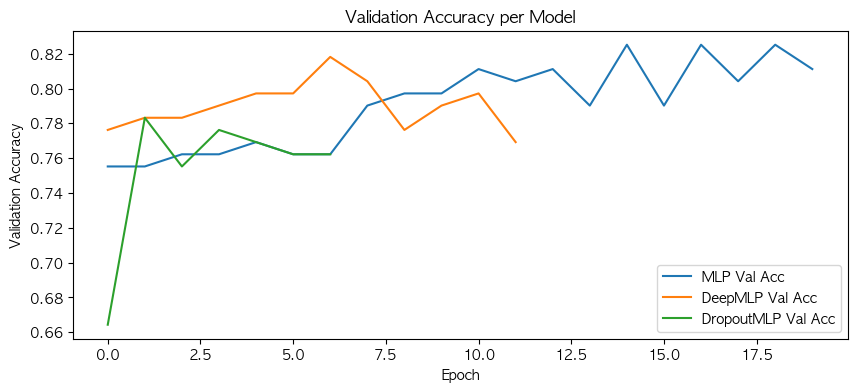

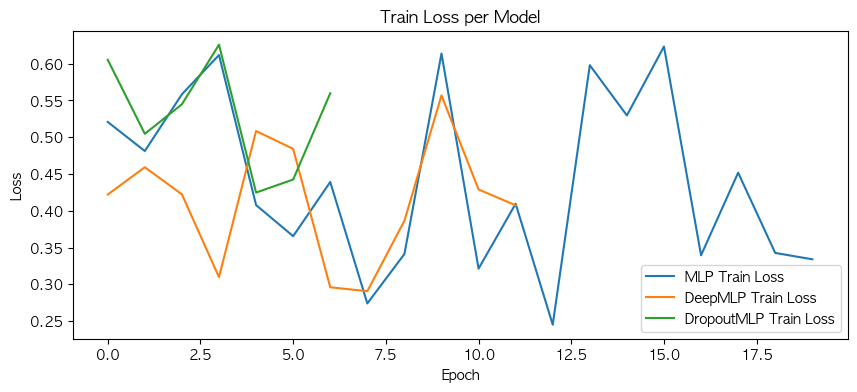

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)
df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']].dropna()
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
X = df.drop('Survived', axis=1).values
y = df['Survived'].values
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# 다양한 신경망 모델 클래스
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

class DeepMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

class DropoutMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

# 학습 함수 (EarlyStopping 포함)
def train_model(model, optimizer, train_loader, criterion, X_val, y_val, n_epochs=40, patience=5):
    best_acc = 0
    best_model = None
    patience_cnt = 0
    train_loss_hist = []
    val_acc_hist = []
    for epoch in range(n_epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
        # Validation Accuracy
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val).cpu().numpy()
            y_pred_label = (y_pred > 0.5).astype(int)
            acc = (y_pred_label == y_val.numpy()).mean()
            val_acc_hist.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_model = model.state_dict()
            patience_cnt = 0
        else:
            patience_cnt += 1
        train_loss_hist.append(loss.item())
        if patience_cnt >= patience:
            break
    model.load_state_dict(best_model)
    return model, train_loss_hist, val_acc_hist

# 모델 및 옵티마이저 선언
models = [
    MLP(X_train.shape[1]),
    DeepMLP(X_train.shape[1]),
    DropoutMLP(X_train.shape[1])
]
optimizers = [
    torch.optim.Adam(models[0].parameters(), lr=0.01),
    torch.optim.AdamW(models[1].parameters(), lr=0.01),
    torch.optim.SGD(models[2].parameters(), lr=0.05, momentum=0.8)
]
model_names = ['MLP', 'DeepMLP', 'DropoutMLP']

criterion = nn.BCELoss()
train_loss_hists = []
val_acc_hists = []
final_accs = []

# 모델 개별 학습 및 평가
for i, (model, opt, name) in enumerate(zip(models, optimizers, model_names)):
    model, loss_hist, acc_hist = train_model(
        model, opt, train_loader, criterion,
        X_test_tensor, y_test_tensor, n_epochs=40, patience=5
    )
    train_loss_hists.append(loss_hist)
    val_acc_hists.append(acc_hist)
    # 최종 테스트 정확도
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy()
        y_pred_label = (y_pred > 0.5).astype(int)
        acc = (y_pred_label == y_test).mean()
        final_accs.append(acc)
        print(f"[{name}] Test Accuracy: {acc:.3f}")

# 앙상블 (3개 모델 확률 평균)
with torch.no_grad():
    ensemble_probs = sum([m(X_test_tensor).numpy() for m in models]) / len(models)
    ensemble_label = (ensemble_probs > 0.5).astype(int)
    ensemble_acc = (ensemble_label == y_test).mean()
    print(f"[Ensemble] Test Accuracy: {ensemble_acc:.3f}")

# 학습 곡선 시각화
plt.figure(figsize=(10,4))
for i, name in enumerate(model_names):
    plt.plot(val_acc_hists[i], label=f'{name} Val Acc')
plt.title("Validation Accuracy per Model")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
for i, name in enumerate(model_names):
    plt.plot(train_loss_hists[i], label=f'{name} Train Loss')
plt.title("Train Loss per Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
